# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt).
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

This cell imports necessary libraries, preprocesses the data, and generates node embeddings using the node2vec algorithm. The resulting node embeddings are merged with the original dataset, unnecessary columns are dropped, and categorical labels are encoded numerically. Missing values are imputed, and the dataset is split into features (X) and the target variable (y). A RandomForest classifier is then created and optimized using GridSearchCV. The final classifier is trained and evaluated on the test set.

In [9]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create the Network Graph
df = pd.read_csv("Contact-diaries-network_data_2013.csv", names=["0"])
df[['student_i', 'student_j', 'duration']] = df["0"].str.split(expand=True)
df['student_i'] = pd.to_numeric(df['student_i'])
df['student_j'] = pd.to_numeric(df['student_j'])
df['duration'] = pd.to_numeric(df['duration'])
df = df.drop(["0"], axis=1)

G = nx.from_pandas_edgelist(df, 'student_i', 'student_j', ['duration'], create_using=nx.DiGraph())

# Feature Extraction
features = pd.DataFrame(index=G.nodes())

# Example feature: degree centrality
features['degree_centrality'] = pd.Series(nx.degree_centrality(G))

# Example feature: betweenness centrality
# features['betweenness_centrality'] = pd.Series(nx.betweenness_centrality(G))

# Example feature: clustering coefficient
# features['clustering_coefficient'] = pd.Series(nx.clustering(G))

# Label Generation
df['has_link'] = df['duration'].apply(lambda x: 1 if x >= 3 else 0)

# Align indices
features = features.loc[df['student_i']]

# Train a Classifier
X_train, X_test, y_train, y_test = train_test_split(features, df['has_link'], test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the Classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5544554455445545


In [2]:
df

student_i  student_j  duration  has_link
0            3         28         2         1
1            3        106         1         0
2            3        147         4         1
3            3        177         1         0
4            3        295         4         1
..         ...        ...       ...       ...
497       1828       1237         1         0
498       1828       1295         1         0
499       1828       1412         1         0
500       1828       1423         2         1
501       1828       1594         4         1

[502 rows x 4 columns]

In [13]:
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from node2vec import Node2Vec
from sklearn.model_selection import GridSearchCV

#Create the Network Graph
df = pd.read_csv("Contact-diaries-network_data_2013.csv", names=["0"])
df[['student_i', 'student_j', 'duration']] = df["0"].str.split(expand=True)
df['student_i'] = pd.to_numeric(df['student_i'])
df['student_j'] = pd.to_numeric(df['student_j'])
df['duration'] = pd.to_numeric(df['duration'])
df = df.drop(["0"], axis=1)

G = nx.from_pandas_edgelist(df, 'student_i', 'student_j', ['duration'], create_using=nx.DiGraph())

#Generate Node Embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

#Feature Extraction
features = pd.DataFrame(index=G.nodes())

# Example feature: degree centrality
features['degree_centrality'] = pd.Series(nx.degree_centrality(G))

#Generate Node Embedding DataFrame
node_embedding_df = pd.DataFrame(columns=[f'node_embedding_{i}' for i in range(64)], index=features.index)
for node in node_embedding_df.index:
    if str(node) in model.wv:
        node_embedding_df.loc[node] = model.wv[str(node)]

#Merge Node Embedding DataFrame with Feature DataFrame
features = pd.concat([features, node_embedding_df], axis=1)

#Label Generation
df['has_link'] = df['duration'].apply(lambda x: 1 if x >= 2 else 0)

# Align indices
features = features.loc[df['student_i']]

#Align indices and Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(features, df['has_link'], test_size=0.2, random_state=42)

# Define parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_clf = grid_search.best_estimator_

# Step 13: Evaluate the best model
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)

Computing transition probabilities:   0%|          | 0/120 [00:00<?, ?it/s]

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7920792079207921


This cell calculates and prints various evaluation metrics for the RandomForest classifier. It includes accuracy, precision, recall, F1-score, confusion matrix, and a ROC curve with AUC (Area Under the Curve).

In [15]:
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7920792079207921
Precision: 0.8260869565217391
Recall: 0.9382716049382716
F1 Score: 0.8786127167630059
ROC AUC Score: 0.5691358024691358


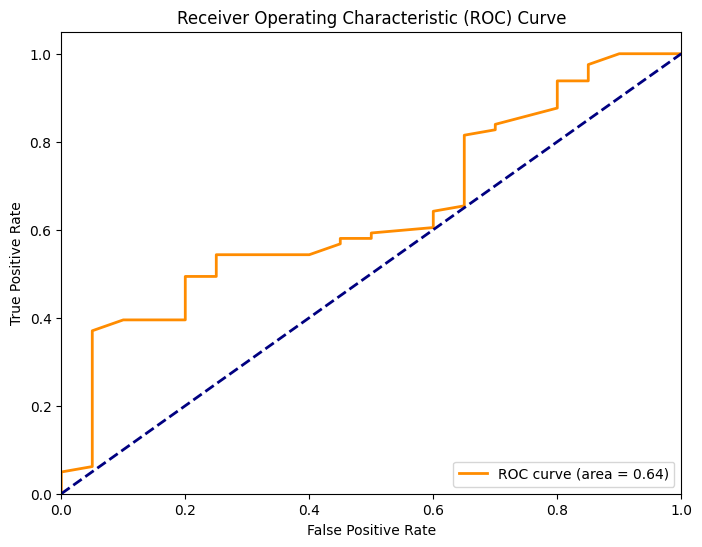

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_prob = best_clf.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw
    the network and visualize one of the centrality measures (10pt)
    

In [23]:
import os, re
from glob import glob
from tqdm import  tqdm 

enron_data_set_path = "./maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()

file_paths = glob(os.path.join(enron_data_set_path, "*", "*", "*"))

# Replace backslashes with forward slashes
file_paths = [path.replace("\\", "/") for path in file_paths]

# Filter the paths
files_list = [p for p in file_paths if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

g = nx.DiGraph()    

Found 99279 files


100%|███████████████████████████████████████████████████████████████████████████| 99279/99279 [12:03<00:00, 137.15it/s]


In [24]:
g = nx.DiGraph()
g.add_edges_from(links)
print(g)

DiGraph with 18590 nodes and 32392 edges


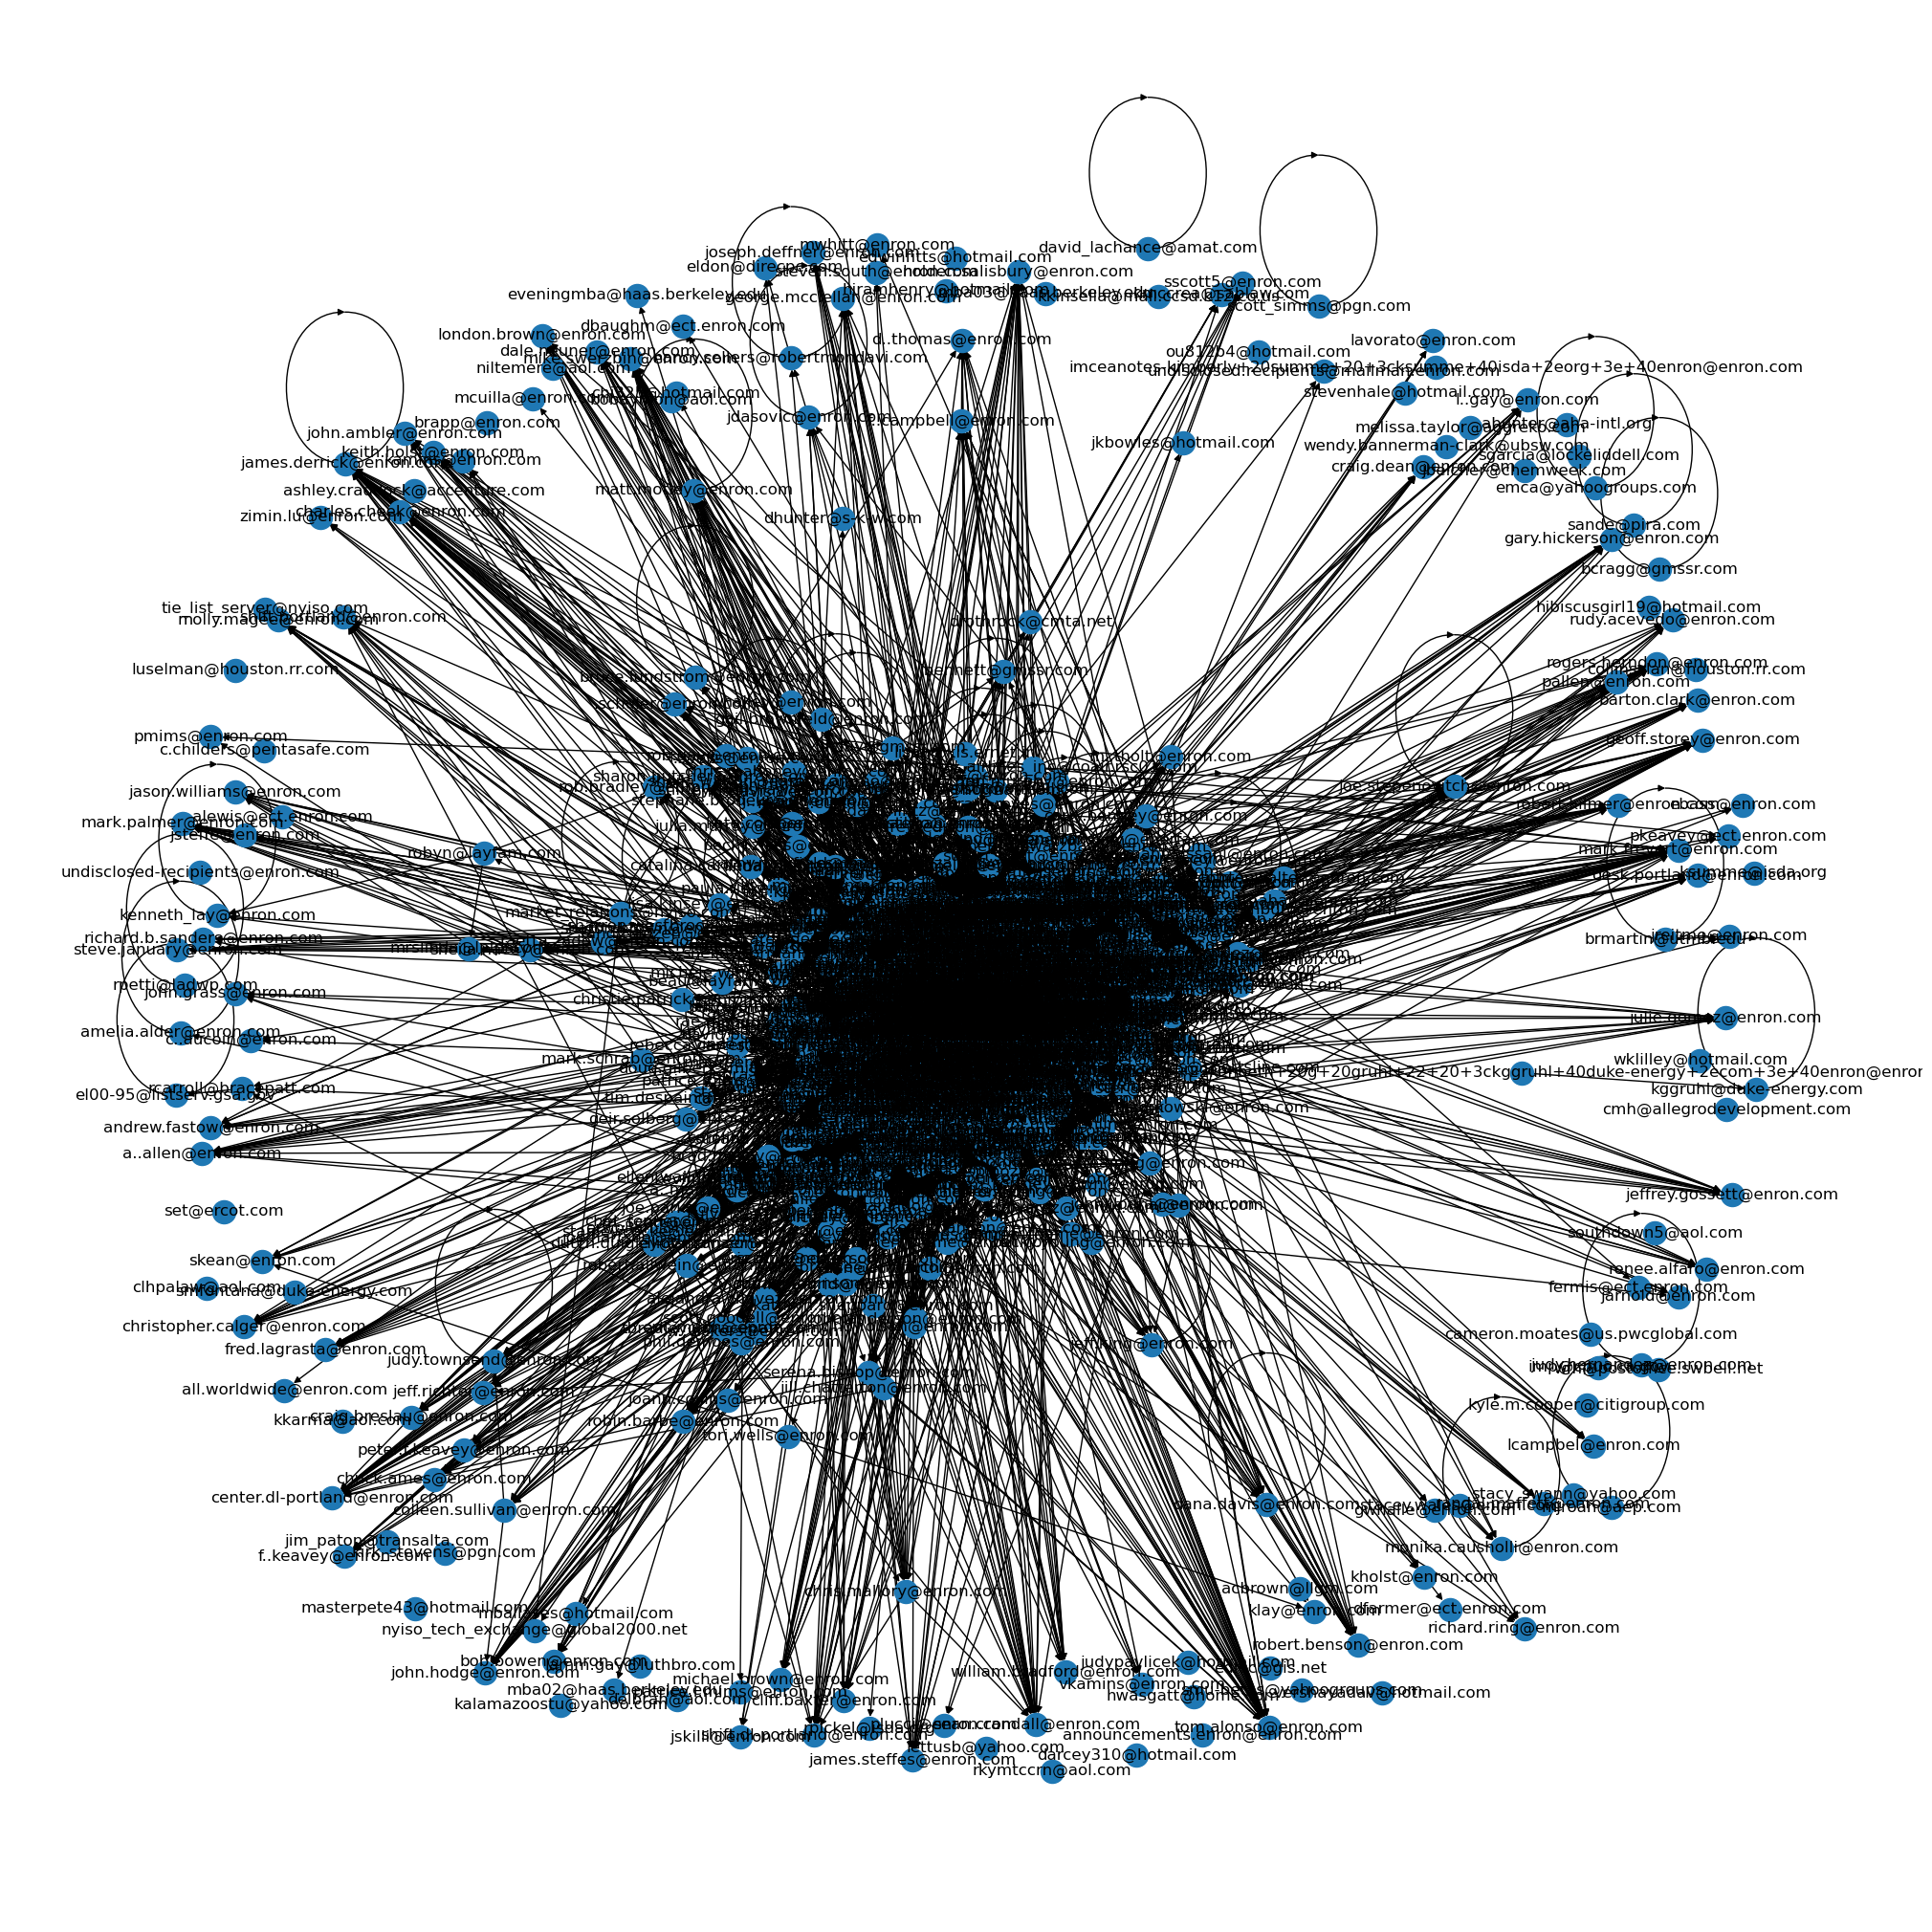

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

l = [n for n,degree in dict(g.degree()).items() if degree > 10]
h = g.subgraph(l)
plt.figure(figsize=(20,20))
# nx.write_gml(h, "./datasets/enron/maildir/network.gml")
nx.draw_spring(h, with_labels=True)

In [26]:
# Degree Centrality
degree_centrality = nx.degree_centrality(g)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(g)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(g)

In [34]:
# From here: https://dsg.tuwien.ac.at/team/dschall/email/enron-employees.txt

'''
albert.meyers Albert Meyers       Employee           Specialist"
a..martin	Thomas Martin           Vice President"
andrea.ring	Andrea Ring         N/A
andrew.lewis	Andrew Lewis            Director
andy.zipper	Andy Zipper            Vice President     Enron Online
a..shankman	Jeffrey Shankman       President          Enron Global Mkts
barry.tycholiz	Barry Tycholiz          Vice President
benjamin.rogers	Benjamin Rogers        Employee           Associate
bill.rapp	Bill Rapp              N/A
bill.williams	xxx
brad.mckay	Bradley Mckay           Employee
brenda.whitehead	xxx
b..sanders	Richard Sanders     Vice President    Enron WholeSale Services
cara.semperger	Cara Semperger      Employee           Senior Analyst Cash
c..giron	Daron Giron         Employee
charles.weldon	Charles Weldon      N/A
chris.dorland	Chris Dorland       Manager
chris.germany	Chris Germany       Employee
clint.dean	xxx
cooper.richey	Cooper Richey       Manager
craig.dean	Craig Dean          Trader
dana.davis	Dana Davis             Vice President     Term
dan.hyvl	Dan Hyvl            Employee
danny.mccarty	Danny McCarty          Vice President
daren.farmer	Daren Farmer        Manager            Logistics Manager
darrell.schoolcraft	Darrell Schoolcraft    N/A
darron.giron	Daron Giron         Employee
david.delainey	David Delainey         CEO                Enron North America and Enron Enery Services
debra.bailey	Susan Bailey           N/A
debra.perlingiere	xxx
diana.scholtes	Diana Scholtes      Trader
d..martin	Thomas Martin           Vice President
don.baughman	Don Baughman        Trader
drew.fossum	Drew Fossum         Vice President
d..steffes	James Steffes          Vice President     Government Affairs
d..thomas	xxx
dutch.quigley	xxx
e..haedicke	Mark Haedicke          Managing Director  Legal Department
elizabeth.sager	Elizabeth Sager        Employee
eric.bass	Eric Bass               Trader
eric.saibi	Eric Saibi          Trader
errol.mclaughlin	Errol McLaughlin    Employee
e.taylor	Mark Taylor            Employee
f..brawner	Sandra Brawner          Director
f..campbell	Larry Campbell         Employee           Senior Specialist
f..keavey	Peter Keavey           Employee
fletcher.sturm	Fletcher Sturm          Vice President
frank.ermis	Frank Ermis             Director
geir.solberg	Geir Solberg        Employee           Analyst
geoff.storey	Geoffery Storey         Director
gerald.nemec	Gerald Nemec           N/A
greg.whalley	Greg Whalley           President
gretel.smith	xxx
harry.arora	Harpreet Arora          Vice President
h..lewis	Andrew Lewis            Director
holden.salisbury	Holden Salisbury    Employee           Cash Analyst
hunter.shively	Hunter Shively          Vice President
james.derrick	James Derrick       In House Lawyer
james.steffes	James Steffes          Vice President     Government Affairs
jane.tholt	Jane Tholt              Vice President
jason.williams	xxx
jason.wolfe	Jason Wolfe            N/A
jay.reitmeyer	Jay Reitmeyer          Employee
jeff.dasovich	Jeff Dasovich          Employee           Government Relation Executive
jeff.king	Jeff King           Manager
jeffrey.hodge	John Hodge          Managing Director
jeffrey.shankman	Jeffrey Shankman       President          Enron Global Mkts
jeff.skilling	Jeffery Skilling    CEO
j..farmer	Daren Farmer        Manager            Logistics Manager
j.harris	xxx
jim.schwieger	Jim Schwieger          Trader
j..kaminski	Vince Kaminski      Manager            Risk Management Head
j.kaminski	Vince Kaminski      Manager            Risk Management Head
j..kean	Steven Kean            Vice President     Vice President & Chief of Staff
joannie.williamson	xxx
joe.parks	Joe Parks           N/A
joe.quenet	Joe Quenet             Trader
joe.stepenovitch	Joe Stepenovitch       Vice President     Enery marketting and trading Florida
john.arnold	John Arnold             Vice President
john.forney	John Forney            Manager            Real time Trading Desk
john.griffith	xxx
john.hodge	John Hodge          Managing Director
john.lavorato	John Lavorato          CEO                Enron America
john.zufferli	John Zufferli          Vice President
jonathan.mckay	Jonathan Mckay          Director
j..sturm	Fletcher Sturm          Vice President
juan.hernandez	Juan Hernandez         Employee           Senior Specialist Logistics
judy.hernandez	xxx
judy.townsend	Judy Townsend       Employee
k..allen	Philip Allen        Manager
kam.keiser	Kam Keiser          Employee
kate.symes	Kate Symes          Employee
kay.mann	Kay Mann               Employee
keith.holst	Keith Holst         Director
kenneth.lay	Kenneth Lay         CEO
kevin.hyatt	Kevin Hyatt            Director           Pipeline Business
kevin.presto	Kevin Presto            Vice President
kevin.ruscitti	Kevin Ruscitti          Trader
kimberly.watson	Kimberly Watson        N/A
kim.ward	Kim Ward               N/A
larry.campbell	Larry Campbell         Employee           Senior Specialist
larry.may	Lawrence May            Director
l..gay	Randall Gay            N/A
lindy.donoho	Lindy Donoho           Employee
lisa.gang	xxx
liz.taylor	xxx
l..mims	Patrice Mims        N/A
louise.kitchen	Louise Kitchen      President          Enron Online
lynn.blair	Lynn Blair          N/A
margaret.carson	xxx
marie.heard	Marie Heard         N/A
mark.e.haedicke	Mark Haedicke          Managing Director  Legal Department
mark.haedicke	Mark Haedicke          Managing Director  Legal Department
mark.mcconnell	xxx
mark.taylor	Mark Taylor            Employee
mark.whitt	Mark Whitt          N/A
martin.cuilla	Martin Cuilla           Manager
mary.fischer	Mary Fischer        Employee
matthew.lenhart	Matthew Lenhart        Employee
matt.motley	Matthew Motley          Director
matt.smith	xxx
m..forney	John Forney            Manager            Real time Trading Desk
michele.lokay	Michelle Lokay         Employee           Administrative Asisstant
michelle.cash	Michelle Cash       N/A
michelle.lokay	Michelle Lokay         Employee           Administrative Asisstant
mike.carson	Mike Carson         Manager
mike.grigsby	Michael Grigsby         Manager
mike.maggi	Michael Maggi           Director
mike.mcconnell	xxx
mike.swerzbin	Mike Swerzbin       Trader
m..love	Phillip Love        N/A
monika.causholli	Monika Causholli    Employee          Analyst Risk Management
monique.sanchez	xxx
m..presto	Kevin Presto            Vice President
m..scott	Susan Scott            N/A
m..smith	xxx
m..tholt	Jane Tholt              Vice President
patrice.mims	Patrice Mims        N/A
paul.thomas	Paul Thomas         N/A
peter.keavey	Peter Keavey           Employee
phillip.allen	Philip Allen        Manager
phillip.love	Phillip Love        N/A
phillip.platter	Phillip Platter     Employee           Sr.Specialist
randall.gay	Randall Gay            N/A
richard.ring	Richard Ring           Employee
richard.sanders	Richard Sanders     Vice President    Enron WholeSale Services
richard.shapiro	Richard Shapiro        Vice President     Regulatory Affairs
rick.buy	Rick Buy            Manager            Chief Risk Management Officer
robert.badeer	Robert Badeer           Director
robert.benson	Robert Benson           Director
rob.gay	xxx
rod.hayslett	Rod Hayslett           Vice President     Also Chief Financial Officer and Treasurer
ryan.slinger	Ryan Slinger        Trader
sally.beck	Sally Beck          Employee           Chief Operating Officer
sandra.brawner	Sandra Brawner          Director
sara.shackleton	xxx
scott.hendrickson	xxx
scott.neal	Scott Neal              Vice President
shelley.corman	Shelley Corman         Vice President     Regulatory Affairs
s..shively	Hunter Shively          Vice President
stacy.dickson	Stacy Dickson          Employee
stanley.horton	Stanley Horton         President          Enron Gas Pipeline
stephanie.panus	Stephanie Panus        Employee
steven.kean	Steven Kean            Vice President     Vice President & Chief of Staff
steven.south	xxx
susan.bailey	Susan Bailey           N/A
susan.pereira	Susan Pereira          Employee
susan.scott	Susan Scott            N/A
s..ward	Kim Ward               N/A
tana.jones	Tana Jones             N/A
teb.lokey	Teb Lokey              Manager            Regulatory Affairs
theresa.staab	Theresa Staab          Employee
t..hodge	John Hodge          Managing Director
thomas.martin	Thomas Martin           Vice President
t..lucci	Paul Lucci          Employee
tom.donohoe	Tom Donohoe            N/A
tori.kuykendall	Tori Kuykendall        Trader
tracy.geaccone	Tracy Geaccone         Employee
vince.kaminski	Vince Kaminski      Manager            Risk Management Head
vladi.pimenov	Vladi Pimenov       N/A
v.weldon	Charles Weldon      N/A
w..delainey	David Delainey         CEO                Enron North America and Enron Enery Services
w..pereira	Susan Pereira          Employee
w..white	Stacey White        N/A
'''

'\nalbert.meyers Albert Meyers       Employee           Specialist"\na..martin\tThomas Martin           Vice President"\nandrea.ring\tAndrea Ring         N/A\nandrew.lewis\tAndrew Lewis            Director\nandy.zipper\tAndy Zipper            Vice President     Enron Online\na..shankman\tJeffrey Shankman       President          Enron Global Mkts\nbarry.tycholiz\tBarry Tycholiz          Vice President\nbenjamin.rogers\tBenjamin Rogers        Employee           Associate\nbill.rapp\tBill Rapp              N/A\nbill.williams\txxx\nbrad.mckay\tBradley Mckay           Employee\nbrenda.whitehead\txxx\nb..sanders\tRichard Sanders     Vice President    Enron WholeSale Services\ncara.semperger\tCara Semperger      Employee           Senior Analyst Cash\nc..giron\tDaron Giron         Employee\ncharles.weldon\tCharles Weldon      N/A\nchris.dorland\tChris Dorland       Manager\nchris.germany\tChris Germany       Employee\nclint.dean\txxx\ncooper.richey\tCooper Richey       Manager\ncraig.dean\tC

In [46]:
# Load the list of employees and their roles from the text file
employees = {}
with open('employees.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            employee_name = parts[0]
            employee_role = parts[-1]
            employees[employee_name] = employee_role

# Function to extract the role of an employee from the list
def get_role(employee_name):
    return employees.get(employee_name, "N/A")

# Function to extract the username from an email address
def extract_username(email):
    return email.split('@')[0]

# Function to compare top managers identified by centrality measures with the list of managers
def evaluate_precision(centrality_measure):
    # Sort nodes by centrality measure in descending order
    sorted_nodes = sorted(centrality_measure.items(), key=lambda x: x[1], reverse=True)
    # Extract top 10 managers
    top_managers = [extract_username(node[0]) for node in sorted_nodes[:10]]  # Extract email address from tuple
    # Count the number of top managers who are actually managers according to the list
    actual_managers = [node for node in top_managers if get_role(node) not in ["N/A", "Employee", "Trader", "In House Lawyer"]]
    return len(actual_managers) / 10 * 100  # Precision in percentage

# Evaluate precision for each centrality measure
precision_degree = evaluate_precision(degree_centrality)
precision_betweenness = evaluate_precision(betweenness_centrality)
precision_closeness = evaluate_precision(closeness_centrality)

print("Precision of Degree Centrality:", precision_degree, "%")
print("Precision of Betweenness Centrality:", precision_betweenness, "%")
print("Precision of Closeness Centrality:", precision_closeness, "%")

Precision of Degree Centrality: 100.0 %
Precision of Betweenness Centrality: 100.0 %
Precision of Closeness Centrality: 90.0 %


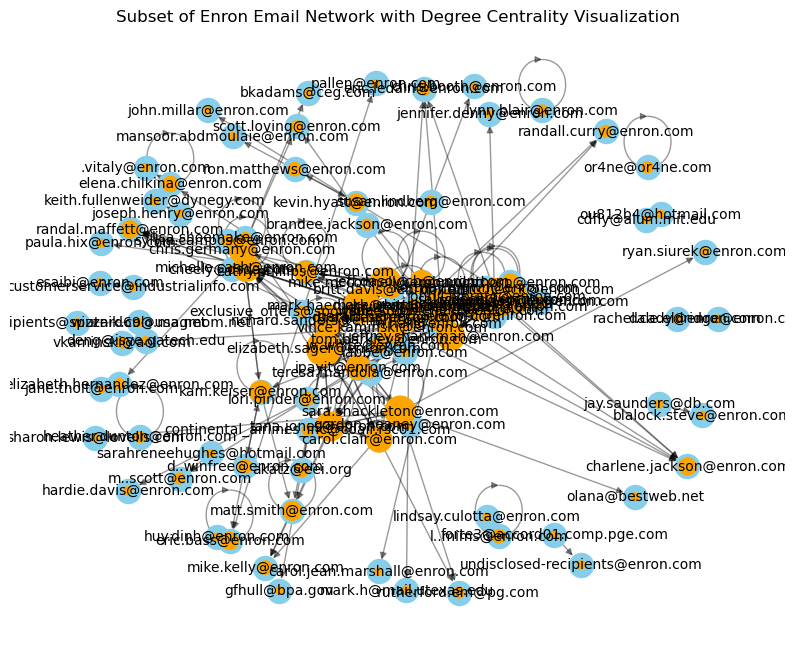

In [52]:
# Did it only for a very small part of the network.
# Extract a subset of nodes
subset_nodes = list(g.nodes())[:100]  # Extracting the first 20 nodes as an example

# Create a subgraph consisting of the subset of nodes
subgraph = g.subgraph(subset_nodes)

# Choose a centrality measure to visualize (e.g., degree centrality)
centrality_measure = nx.degree_centrality(subgraph)

# Draw the subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph)  # Layout for the subgraph

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=300, node_color='skyblue')

# Draw edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.4)

# Draw labels
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_family='sans-serif')

# Calculate node sizes based on the chosen centrality measure
node_sizes = [3000 * centrality_measure[node] for node in subgraph.nodes()]

# Draw nodes with sizes based on the chosen centrality measure
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='orange')

# Add title
plt.title("Subset of Enron Email Network with Degree Centrality Visualization")

# Show plot
plt.axis('off')  # Turn off axis
plt.show()